<a href="https://colab.research.google.com/github/wkotala/DNN-HW1/blob/main/DNN-homework-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Multitask Learning for Geometric Shape Classification and Counting**

# Setup

In [38]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip -o data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-22 23:40:40--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-22 23:40:41--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.04s   

2025-11-22 23:40:41 (148 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [39]:
# TODO: install all required dependencies

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import sys
import plotly.graph_objects as go

from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass, replace
from typing import Callable, Type
from plotly.subplots import make_subplots
from IPython.display import display
from enum import Enum

if "google.colab" in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()

torch.manual_seed(1)

# Exploratory Data Analysis

In [41]:
data_dir = Path('data')
labels_df = pd.read_csv(data_dir / 'labels.csv')
labels_df

,name,squares,circles,up,right,down,left
0,img_00000.png,0,0,4,0,6,0
1,img_00001.png,0,0,0,5,0,5
2,img_00002.png,0,0,8,0,2,0
3,img_00003.png,0,7,0,0,0,3
4,img_00004.png,0,0,3,0,0,7
...,...,...,...,...,...,...,...
9995,img_09995.png,3,0,7,0,0,0
9996,img_09996.png,8,0,2,0,0,0
9997,img_09997.png,8,0,0,0,0,2
9998,img_09998.png,6,0,0,4,0,0


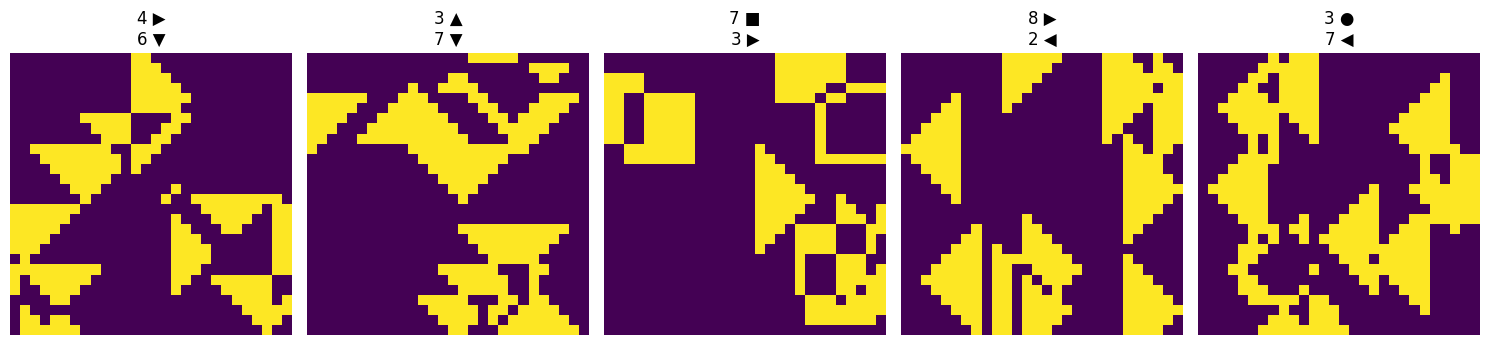

In [42]:
sample_df = labels_df[10:15]
shapes = {
    'squares': '\u25A0',
    'circles': '\u25CF',
    'up': '\u25B2',
    'right': '\u25B6',
    'down': '\u25BC',
    'left': '\u25C0',
}

fig, axes = plt.subplots(1, len(sample_df), figsize=(15, 4))

for ax, row in zip(axes, sample_df.itertuples()):
    # Plot the image.
    img_path = data_dir / row.name
    img = Image.open(img_path).convert('L')
    ax.imshow(img)

    # Display info about shapes in the image.
    title_parts = [
        f'{count} {shape_symbol}'
        for shape_name, shape_symbol in shapes.items()
        if (count := getattr(row, shape_name)) > 0
    ]
    ax.set_title('\n'.join(title_parts))
    ax.axis('off')

plt.tight_layout()
plt.show()

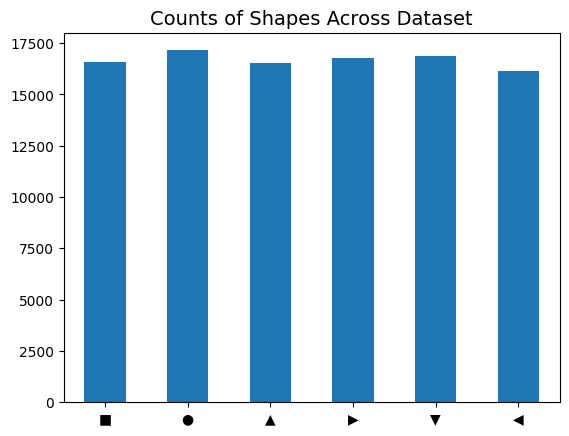

In [43]:
plt.title('Counts of Shapes Across Dataset', fontsize=14)
labels_df.drop('name', axis=1).sum().rename(shapes).plot.bar(rot=0)
plt.show()

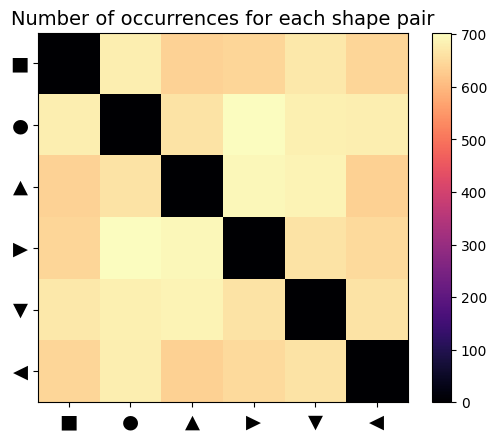

In [44]:
occurrence = (labels_df.drop('name', axis=1) > 0).astype(int)
co_occurrence = occurrence.T @ occurrence
for i in range(len(co_occurrence)):
    co_occurrence.iat[i,i] = 0

# Draw a heatmap.
plt.title('Number of occurrences for each shape pair', fontsize=14)
plt.imshow(co_occurrence, cmap='magma')
plt.colorbar()

# Label the axes.
tick_positions = np.arange(len(co_occurrence.columns))
tick_labels = [shapes[name] for name in co_occurrence.columns]
plt.xticks(tick_positions, tick_labels, fontsize=14)
plt.yticks(tick_positions, tick_labels, fontsize=14, va='center')

plt.show()

In [45]:
# TODO: check how many of each classes are there

# Data pipeline

## Augmentations

In [46]:
class RandomTransformator:
    """
    Assumes shapes are in order: squares, circles, up, right, down, left.
    """

    def __call__(self, img: Tensor, counts: Tensor) -> tuple[Tensor, Tensor]:
        """ Performs random transformations. """
        img, counts = self.horizontal_flip(img, counts, p=0.5)
        img, counts = self.vertical_flip(img, counts, p=0.5)
        img, counts = self.rotation(img, counts)
        return img, counts

    def horizontal_flip(self, img: Tensor, counts: Tensor, p: float = 1) -> tuple[Tensor, Tensor]:
        """ Flips image horizontally with probability = p """
        if torch.rand(1) < p:
            img = img.flip(2)
            counts[3], counts[5] = counts[5].item(), counts[3].item()

        return img, counts

    def vertical_flip(self, img: Tensor, counts: Tensor, p: float = 1) -> tuple[Tensor, Tensor]:
        """ Flips image vertically with probability = p """
        if torch.rand(1) < p:
            img = img.flip(1)
            counts[2], counts[4] = counts[4].item(), counts[2].item()

        return img, counts

    def rotation(self, img: Tensor, counts: Tensor) -> tuple[Tensor, Tensor]:
        """ Rotates image by random angle from: 0, pi/2, pi, -pi/2 """
        k = torch.randint(-1, 3, size=(1,)).item()
        img = img.rot90(k=k, dims=(1,2))

        triangles_shifted = torch.roll(counts[2:], -k)
        counts[2:] = triangles_shifted

        return img, counts

## Dataset

In [47]:
class GSNDataset(Dataset):
    """
    Custom PyTorch Dataset for the Geometric Shape Numbers (GSN) dataset.

    GSNDataset handles two tasks:
    1. Classification: Identifying which of the 135 possible shape-pair
       and count-split configurations is present in the image.
    2. Regression: Predicting the count of 6 different shape types.
    """

    def __init__(self, data_dir: Path, train: bool, train_val_split: float = 0.9, transform: Callable | None = None):
        """
        Input:
        - data_dir: Path to the directory containing 'labels.csv' and all the images.
        - train: A boolean indicating whether to create train or validation dataset.
        - train_val_split: Fraction specifying what percentage of data is train data; the rest is validation data.
        - transform: Optional transform to be applied on a sample.
                     transform should implement __call__(image, counts) -> (transformed_image, transformed_counts),
                     where images is a tensor of shape (C=1, H=28, W=28),
                     and counts is a tensor of shape (6,), with count of shapes in the same order as in self.shape_names()
        """
        self.data_dir = data_dir
        self.transform = transform

        all_labels_df = pd.read_csv(data_dir / 'labels.csv')
        train_len = round(len(all_labels_df) * train_val_split)

        if train:
            self.labels_df = all_labels_df[:train_len].reset_index(drop=True)
        else:
            self.labels_df = all_labels_df[train_len:].reset_index(drop=True)

        self.shape_columns = list(self.labels_df.drop('name', axis=1).columns)

        self._pair_to_id = dict()
        pair_id = 0
        for i in range(len(self.shape_columns)):
            for j in range(i + 1, len(self.shape_columns)):
                self._pair_to_id[(i, j)] = pair_id
                pair_id += 1

    def shape_names(self) -> list[str]:
        """
        Returns list of shape names used in dataset.
        Order of the shapes in this list dictates:
        - Order of count labels for regression model.
        - Class labels for classification model:
            - classes 0...8 contain shapes list[0], list[1]
            - classes 9...17 contain shapes list[0], list[2],
            ...
            - classes 36...44 contain shapes list[0], list[5],
            - classes 45...53 contain shapes list[1], list[2],
            ...
            - classes 126...134 contain shapes list[4], list[5].
        """
        return self.shape_columns

    def _calculate_class_from_shapes_counts(self, counts: Tensor) -> Tensor:
        """
        Translates shape configurations into unique class labels.

        Input: counts of each shape in an image as tensor of shape (6,)
        Output: class label, i.e. integer in [0, 134], as Tensor
        """
        nonzero_indices = torch.nonzero(counts, as_tuple=True)[0]
        assert len(nonzero_indices) == 2
        assert counts[nonzero_indices].sum() == 10

        pair = tuple(nonzero_indices.tolist())
        assert pair in self._pair_to_id
        return self._pair_to_id[pair] * 9 + counts[pair[0]] - 1

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor, Tensor]:
        """
        Output:
        - image as tensor of shape (C=1, H=28, W=28)
        - class label as tensor of shape (1,)
        - true counts as tensor of shape (6,)
        """
        row = self.labels_df.iloc[idx]
        img_path = self.data_dir / row['name']
        img = Image.open(img_path).convert('L')
        img_tensor = transforms.functional.to_tensor(img)

        counts = torch.tensor(row[self.shape_columns].astype(np.float32).to_numpy(), dtype=torch.float32)

        if self.transform:
            img_tensor, counts = self.transform(img_tensor, counts)

        class_label = self._calculate_class_from_shapes_counts(counts).to(torch.long)

        return img_tensor, class_label, counts

# TODO: check if transformations dont compute gradients

# TODO: change shape_columns in __init__ if doesn't match expectations

# Model architecture

In [48]:
class MultitaskModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(), # (B, 8, H, W)
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(), # (B, 16, H, W)
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), # (B, 32, H, W)
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(), # (B, 64, H, W)
            nn.Flatten(start_dim=1), # (B, 64 * H * W)
            nn.Linear(64 * 28 * 28, 256), nn.ReLU() # (B, 256)
        )

        # TODO: experiment with the heads

        self.head_cls = nn.Sequential(
            nn.Linear(256, 256), # (B, 256)
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 135), # (B, 135)
            nn.LogSoftmax(dim=1)
        )

        self.head_cnt = nn.Sequential(
            nn.Linear(256, 128), # (B, 128)
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 6), # (B, 6)
        )

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Input shape: (B, 1, H, W).
        Output:
        - classification log-probabilities (B, 135)
        - regression counts (B, 6)
        """
        features = self.backbone(x)
        log_probs = self.head_cls(features)
        counts = self.head_cnt(features)
        return log_probs, counts

# Training & Evaluation

## Setup

In [49]:
@dataclass
class TrainingSettings:
    device: torch.device

    learning_rate: float = 1e-3
    max_epochs: int = 100
    train_batch_size: int = 64

    cls_loss_fn: Callable = F.nll_loss        # classification loss function
    lambda_cls: float = 1.0                   # weight of classification loss function
    cnt_loss_fn: Callable = F.smooth_l1_loss  # regression loss function
    lambda_cnt: float = 1.0                   # weight of regression loss function

    early_stop_patience: int = 10

    optimizer: Type[torch.optim.Optimizer] = torch.optim.Adam

## Evaluation

In [50]:
class ClassificationMetricsCalculator:
    """
    Calculates classification metrics.
    Each method follows the convention:
    Input:
    - predicted classes as tensor of shape (B,)
    - actual classes as tensor of shape (B,)
    Output:
    - calculated metric as float
    """

    def __init__(self, eps: float = 1e-8):
        self.n_classes = 135
        self.eps = eps

    def top_1_accuracy(self, pred_class: Tensor, actual_class: Tensor) -> float:
        return (pred_class == actual_class).to(torch.float32).mean().item()

    def macro_f1(self, pred_class: Tensor, actual_class: Tensor) -> float:
        tp = torch.zeros(self.n_classes, device=pred_class.device)
        fp = torch.zeros(self.n_classes, device=pred_class.device)
        fn = torch.zeros(self.n_classes, device=pred_class.device)

        for i in range(self.n_classes):
            tp[i] = ((pred_class == i) & (actual_class == i)).sum()
            fp[i] = ((pred_class == i) & (actual_class != i)).sum()
            fn[i] = ((pred_class != i) & (actual_class == i)).sum()

        f1 = 2 * tp / (2 * tp + fp + fn + self.eps)

        classes_present = (tp + fn) > 0
        f1 = f1[classes_present]
        return f1.mean().item()


    def per_pair_accuracy(self, pred_class: Tensor, actual_class: Tensor) -> float:
        per_pair_accuracy_sum = 0.0
        num_pairs_present = 0

        for i in range(0, self.n_classes, 9):
            mask = (i <= actual_class) & (actual_class <= i + 8)
            if mask.any():
                per_pair_accuracy_sum += self.top_1_accuracy(pred_class[mask], actual_class[mask])
                num_pairs_present += 1

        per_pair_accurace_average = per_pair_accuracy_sum / num_pairs_present if num_pairs_present > 0 else float('nan')
        return per_pair_accurace_average

class RegressionMetricsCalculator:
    """
    Calculates regression metrics.
    Each method follows the convention:
    Input:
    - predicted counts as tensor of shape (B, 6)
    - actual counts as tensor of shape (B, 6)
    Output:
    - calculated per-class metric as tensor of shape (6,)
    - calculated overall metric as tensor of shape (6,)
    """

    def mae_per_class(self, pred_counts: Tensor, actual_counts: Tensor) -> Tensor:
        absolute_error = torch.abs(pred_counts - actual_counts)
        return absolute_error.mean(dim=0)

    def mae(self, pred_counts: Tensor, actual_counts: Tensor) -> float:
        absolute_error = torch.abs(pred_counts - actual_counts)
        return absolute_error.mean().item()

    def rmse_per_class(self, pred_counts: Tensor, actual_counts: Tensor) -> Tensor:
        squared_error = torch.square(pred_counts - actual_counts)
        return torch.sqrt(squared_error.mean(dim=0))

    def rmse(self, pred_counts: Tensor, actual_counts: Tensor) -> float:
        squared_error = torch.square(pred_counts - actual_counts)
        return torch.sqrt(squared_error.mean()).item()


class MetricsCalculator:
    def __init__(self):
        self.cls = ClassificationMetricsCalculator()
        self.cnt = RegressionMetricsCalculator()

# TODO: revisit this implementation



# TODO: rmse and mae overall - what do they mean???
# TODO: per-pair accuracy: one or six results

# TODO: change all "" to '' everywhere in notebook

In [51]:
class TraceName(str, Enum):
    TRAIN_CLS = 'train cls loss'
    TRAIN_CNT = 'train cnt loss'
    TRAIN_LOSS = 'train loss'

    VAL_CLS = 'val cls loss'
    VAL_CNT = 'val cnt los'
    VAL_LOSS = 'val loss'
    VAL_ACC = 'val accuracy'
    VAL_RMSE = 'val RMSE'

class TrainingVisualizer: # TODO: maybe plot scaled loss
    def __init__(self, dashboard_title: str):
        """
            Defines layout of the training dashboard and displays empty plots.
        """

        # Data that will be visualized.
        self.data = {trace_name: [] for trace_name in TraceName}

        # Layout.
        plots = make_subplots(
            rows=2, cols=3,
            specs=[[{"colspan": 3}, None, None],
                   [{}, {}, {}]],
            subplot_titles=("Training Losses", "Validation Losses", "Validation Accuracy", "Validation RMSE"),
        ).update_layout(
            template='plotly_dark',
            height=800,
            title_text=dashboard_title,
        )

        plots.update_xaxes(title_text='Epoch')
        plots.update_yaxes(title_text="Average Loss Value", col=1)
        plots.update_yaxes(title_text="Accuracy %", row=2, col=2)
        plots.update_yaxes(title_text="RMSE Value", row=2, col=3)

        # Traces.
        train_losses_pos = {'row': 1, 'col': 1}
        val_losses_pos = {'row': 2, 'col': 1}

        traces_config = [ # list  of tuples (name, position)
            (TraceName.TRAIN_CLS, train_losses_pos),
            (TraceName.TRAIN_CNT, train_losses_pos),
            (TraceName.TRAIN_LOSS, train_losses_pos),
            (TraceName.VAL_CLS, val_losses_pos),
            (TraceName.VAL_CNT, val_losses_pos),
            (TraceName.VAL_LOSS, val_losses_pos),
            (TraceName.VAL_ACC, {'row': 2, 'col': 2}),
            (TraceName.VAL_RMSE, {'row': 2, 'col': 3})
        ]

        for name, pos in traces_config:
            plots.add_trace(go.Scatter(name=name), **pos)

        # Display the plots as widget that will be updated each epoch.
        self.plots = go.FigureWidget(plots)
        self.traces = {trace.name: trace for trace in self.plots.data}
        display(self.plots)

    def _update_plot(self, updates: dict[TraceName, float], curr_len: int):
        with self.plots.batch_update():
            new_len = curr_len + 1
            x_axis = list(range(1, new_len + 1))

            for trace_name, value in updates.items():
                self.data[trace_name].append(value)
                self.traces[trace_name].x = x_axis
                self.traces[trace_name].y = self.data[trace_name]

    def plot_train(self, cls_loss: float, cnt_loss: float, loss: float):
        """
        Updates the dashboard with data from train phase.
        """
        self._update_plot({
            TraceName.TRAIN_CLS: cls_loss,
            TraceName.TRAIN_CNT: cnt_loss,
            TraceName.TRAIN_LOSS: loss

        }, len(self.data[TraceName.TRAIN_LOSS]))

    def plot_val(self, cls_loss: float, cnt_loss: float, loss: float, accuracy: float, rmse: float):
        """
        Updates the dashboard with data from validation phase.
        """
        self._update_plot({
            TraceName.VAL_CLS: cls_loss,
            TraceName.VAL_CNT: cnt_loss,
            TraceName.VAL_LOSS: loss,
            TraceName.VAL_ACC: accuracy * 100, # convert to %
            TraceName.VAL_RMSE: rmse

        }, len(self.data[TraceName.VAL_LOSS]))

In [52]:
def evaluate(model: nn.Module, loader: DataLoader, settings: TrainingSettings, calc: MetricsCalculator, visualizer: TrainingVisualizer) -> None:
    model.eval()

    with torch.no_grad():
        for images, class_labels, counts in loader:
            images = images.to(settings.device)
            class_labels = class_labels.to(settings.device)
            counts = counts.to(settings.device)

            log_probs, pred_counts = model(images)

            cls_loss = settings.cls_loss_fn(log_probs, class_labels)
            cnt_loss = settings.cnt_loss_fn(pred_counts, counts)
            loss = settings.lambda_cls * cls_loss + settings.lambda_cnt * cnt_loss

            pred_class = torch.argmax(log_probs, dim=1)

        accuracy = calc.cls.top_1_accuracy(pred_class, class_labels)
        rmse = calc.cnt.rmse(pred_counts, counts)
        visualizer.plot_val(cls_loss.item(), cnt_loss.item(), loss.item(), accuracy, rmse)

    return loss.item() # TODO: make it not assume batch size = len(dataset)

## Training

In [53]:
def train_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, settings: TrainingSettings, visualizer: TrainingVisualizer) -> None:
    model.train()
    total_correct = 0
    total_cls_loss = 0.0
    total_cnt_loss = 0.0

    for images, class_labels, counts in loader:
        images = images.to(settings.device)
        class_labels = class_labels.to(settings.device)
        counts = counts.to(settings.device)

        optimizer.zero_grad()

        log_probs, pred_counts = model(images)

        cls_loss = settings.cls_loss_fn(log_probs, class_labels)
        cnt_loss = settings.cnt_loss_fn(pred_counts, counts)
        loss = settings.lambda_cls * cls_loss + settings.lambda_cnt * cnt_loss

        loss.backward()
        optimizer.step()

        # TODO: this should be visualizer's task probably
        with torch.no_grad():
            pred_class = torch.argmax(log_probs, dim=1)
            total_correct += (pred_class == class_labels).sum().item()
            total_cls_loss += cls_loss.item()
            total_cnt_loss += cnt_loss.item()


    avg_cls_loss = total_cls_loss / len(loader)
    avg_cnt_loss = total_cnt_loss / len(loader)
    avg_total_loss = settings.lambda_cls * avg_cls_loss + settings.lambda_cnt * avg_cnt_loss
    print(f'Classification loss: {avg_cls_loss}')
    print(f'Regression loss: {avg_cnt_loss}')
    print(f'Total loss: {avg_total_loss}')
    print(f'Accuracy: {total_correct / len(loader.dataset) * 100  :.2f}%')

In [54]:
class EarlyStopper:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

# TODO: TrainingReporter

def train_loop(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, settings: TrainingSettings, calc: MetricsCalculator, visualizer: TrainingVisualizer) -> None:
    optimizer = settings.optimizer(model.parameters(), lr=settings.learning_rate)
    early_stopper = EarlyStopper(patience=settings.early_stop_patience)

    for epoch in range(settings.max_epochs):
        print(f'Epoch {epoch + 1}')
        train_epoch(model, train_loader, optimizer, settings, visualizer)
        val_loss = evaluate(model, val_loader, settings, calc, visualizer)

        if early_stopper(val_loss):
            print(f"Early stopping triggered!")
            break

        print()

# Experiments

In [55]:
data_dir = Path('data')
transformator = RandomTransformator()
train_dataset = GSNDataset(data_dir, train=True, transform=transformator)
val_dataset = GSNDataset(data_dir, train=False, transform=None)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
base_settings = TrainingSettings(device=device)

kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {}
train_loader = DataLoader(train_dataset, batch_size=base_settings.train_batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), **kwargs)

calc = MetricsCalculator()

In [56]:
visualizer = TrainingVisualizer('Classification-only model')
settings = replace(base_settings, lambda_cnt = 0)
model = MultitaskModel().to(device)
train_loop(model, train_loader, val_loader, settings, calc, visualizer)

FigureWidget({
    'data': [{'name': <TraceName.TRAIN_CLS: 'train cls loss'>,
              'type': 'scatter',
              'uid': 'b73b3f63-974e-4dbf-907d-8c1724918d5d',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_CNT: 'train cnt loss'>,
              'type': 'scatter',
              'uid': '49c349cc-1a0f-457b-a6bb-2f791c5606c1',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_LOSS: 'train loss'>,
              'type': 'scatter',
              'uid': '04033edb-5c04-441d-80bd-a085d348462f',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.VAL_CLS: 'val cls loss'>,
              'type': 'scatter',
              'uid': '2d9ecd33-0353-4ba3-b2c3-d05a2a406d9a',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'name': <TraceName.VAL_CNT: 'val cnt los'>,
              'type': 'scatter',
              'uid': '87bc423b-65da-4b5a-80

Epoch 1
Classification loss: 4.742979350664937
Regression loss: 1.5139121087730354
Total loss: 4.742979350664937
Accuracy: 1.09%

Epoch 2
Classification loss: 4.686013769596181
Regression loss: 1.5115017603475152
Total loss: 4.686013769596181
Accuracy: 0.82%

Epoch 3
Classification loss: 4.355195875708938
Regression loss: 1.514716718213778
Total loss: 4.355195875708938
Accuracy: 1.91%

Epoch 4
Classification loss: 3.7616316190002657
Regression loss: 1.51950204372406
Total loss: 3.7616316190002657
Accuracy: 4.91%

Epoch 5
Classification loss: 3.2008371133330864
Regression loss: 1.5493968589931515
Total loss: 3.2008371133330864
Accuracy: 8.52%

Epoch 6
Classification loss: 2.7786753160733704
Regression loss: 1.5679510231559157
Total loss: 2.7786753160733704
Accuracy: 13.29%

Epoch 7
Classification loss: 2.390903518555012
Regression loss: 1.574717269721606
Total loss: 2.390903518555012
Accuracy: 20.99%

Epoch 8
Classification loss: 2.1695541177235595
Regression loss: 1.5811888157053198
To

KeyboardInterrupt: 

In [57]:
visualizer = TrainingVisualizer('Regression-only model')
settings = replace(base_settings, lambda_cls = 0)
model = MultitaskModel().to(device)
train_loop(model, train_loader, val_loader, settings, calc, visualizer)

FigureWidget({
    'data': [{'name': <TraceName.TRAIN_CLS: 'train cls loss'>,
              'type': 'scatter',
              'uid': 'e10c6403-952a-4c03-9b31-a71c1b67c465',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_CNT: 'train cnt loss'>,
              'type': 'scatter',
              'uid': 'ec776c7e-0253-4fea-828c-a6f399d03782',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_LOSS: 'train loss'>,
              'type': 'scatter',
              'uid': 'aa00d9a8-a566-4886-a7e8-8719aa2b22bf',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.VAL_CLS: 'val cls loss'>,
              'type': 'scatter',
              'uid': 'f869a28e-09aa-4315-8550-a89395155685',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'name': <TraceName.VAL_CNT: 'val cnt los'>,
              'type': 'scatter',
              'uid': 'f98b8932-cc42-480e-89

Epoch 1
Classification loss: 2.178209017354546
Regression loss: 0.6160998114034639
Total loss: 0.6160998114034639
Accuracy: 36.48%

Epoch 2
Classification loss: 1.6680304623664695
Regression loss: 0.3670995387625187
Total loss: 0.3670995387625187
Accuracy: 41.29%

Epoch 3
Classification loss: 1.6456905222953635
Regression loss: 0.3172887546796325
Total loss: 0.3172887546796325
Accuracy: 40.16%

Epoch 4
Classification loss: 1.604719342914879
Regression loss: 0.30256500015867516
Total loss: 0.30256500015867516
Accuracy: 41.64%

Epoch 5
Classification loss: 1.6250417528423011
Regression loss: 0.28842254669953743
Total loss: 0.28842254669953743
Accuracy: 39.77%

Epoch 6
Classification loss: 1.7010908786286698
Regression loss: 0.2764284840078219
Total loss: 0.2764284840078219
Accuracy: 38.16%

Epoch 7
Classification loss: 1.7317347805550758
Regression loss: 0.27218876641692846
Total loss: 0.27218876641692846
Accuracy: 36.83%

Epoch 8
Classification loss: 1.780606028881479
Regression loss: 0

KeyboardInterrupt: 

In [63]:
visualizer = TrainingVisualizer('Multitask model')
settings = replace(base_settings, lambda_cnt=3.4)
model = MultitaskModel().to(device)
train_loop(model, train_loader, val_loader, settings, calc, visualizer)

FigureWidget({
    'data': [{'name': <TraceName.TRAIN_CLS: 'train cls loss'>,
              'type': 'scatter',
              'uid': '9f1013f7-e28e-46e8-abcf-c01e959c0557',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_CNT: 'train cnt loss'>,
              'type': 'scatter',
              'uid': 'af4d9d72-7ed0-4568-bb36-3e8d7b996ea8',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_LOSS: 'train loss'>,
              'type': 'scatter',
              'uid': '66a79bcd-a9b6-430c-b02e-2f81dabbfd23',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.VAL_CLS: 'val cls loss'>,
              'type': 'scatter',
              'uid': '7a1b85f5-ea06-424e-969a-025ce7d9f9ad',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'name': <TraceName.VAL_CNT: 'val cnt los'>,
              'type': 'scatter',
              'uid': 'c046e1cf-98b5-43cf-85

Epoch 1
Classification loss: 4.627278909615591
Regression loss: 1.384721575053871
Total loss: 9.335332264798753
Accuracy: 1.59%

Epoch 2
Classification loss: 4.03261776680642
Regression loss: 1.2300384661830064
Total loss: 8.214748551828642
Accuracy: 3.11%

Epoch 3
Classification loss: 3.433424542136226
Regression loss: 0.971536970307641
Total loss: 6.736650241182206
Accuracy: 8.07%

Epoch 4
Classification loss: 2.8499035750720516
Regression loss: 0.763516460327392
Total loss: 5.445859540185184
Accuracy: 13.70%

Epoch 5
Classification loss: 2.4802079606563487
Regression loss: 0.6447940208810441
Total loss: 4.672507631651898
Accuracy: 19.08%

Epoch 6
Classification loss: 2.1826376695159477
Regression loss: 0.4917859175103776
Total loss: 3.854709789051231
Accuracy: 23.04%

Epoch 7
Classification loss: 1.9697771435933755
Regression loss: 0.4369046043419669
Total loss: 3.455252798356063
Accuracy: 27.02%

Epoch 8
Classification loss: 1.8862493173450443
Regression loss: 0.4143365703998728
To